In [1]:
import pandas as pd
from pandas_datareader import data as pdr
from datetime import date
from datetime import datetime
import yfinance as yf
yf.pdr_override()
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def SaveData(df, filename):
    df.to_csv(r'data/'+filename+'.csv')
    
def GetData(ticker_list, start_date, end_date):
    print(ticker_list)
    df=[]
    for ticker in ticker_list:
        #print(ticker)
        data = pdr.get_data_yahoo(ticker, start=start_date, end=end_date, progress=False)
        data['Symbol'] = ticker 
        df.append(data)
    print("Data Download Completed")
    return df

## Stocks data from Yahoo Finance using yfinance:

In [3]:
# Tickers list to download
ticker_list=['NIO','AAPL', 'V', 'BAC', 'NFLX', 'DJI']

# Dates
today = date.today()
start_date = '2020-01-03'
end_date = '2020-05-02'

# Get the Data
df = GetData(ticker_list, start_date, end_date)
df = pd.concat(df)
df = df.reset_index()
df = df[['Date', 'Adj Close', 'Symbol']]
stocks = df.pivot('Date','Symbol','Adj Close').reset_index()

# Saving the data
SaveData(stocks,'stocks-'+str(start_date)+'|'+str(end_date))

['NIO', 'AAPL', 'V', 'BAC', 'NFLX', 'DJI']
Data Download Completed


In [4]:
stocks

Symbol,Date,AAPL,BAC,DJI,NFLX,NIO,V
0,2020-01-02,73.840042,34.709141,NaN,329.809998,3.72,189.950775
1,2020-01-03,73.122154,33.988472,28634.900391,325.899994,3.83,188.440079
2,2020-01-06,73.704819,33.939774,28703.400391,335.829987,3.68,188.032593
3,2020-01-07,73.358185,33.715782,28583.699219,330.750000,3.24,187.535660
4,2020-01-08,74.538239,34.056641,28745.099609,339.260010,3.39,190.745880
...,...,...,...,...,...,...,...
79,2020-04-27,69.781609,23.002846,24133.800781,421.380005,3.24,170.956451
80,2020-04-28,68.650490,23.414486,24101.500000,403.829987,3.34,170.448853
81,2020-04-29,70.905334,24.286774,24633.900391,411.890015,3.61,180.939529
82,2020-04-30,72.401154,23.571302,24345.699219,419.850006,3.41,177.883911


In [5]:
# Calculate daily log returns
daily_returns = np.log(stocks[ticker_list]/stocks[ticker_list].shift(-1))
daily_returns.insert(0, 'Date', stocks['Date'])

# Calculate daily standard deviation of returns
daily_std = np.std(daily_returns)

# Annualized daily standard deviation
std = daily_std * 252 ** 0.5

# Computing weekly volatility for log returns (90% sure it is wrong)
weekly_volatility = daily_returns.rolling(5).std()

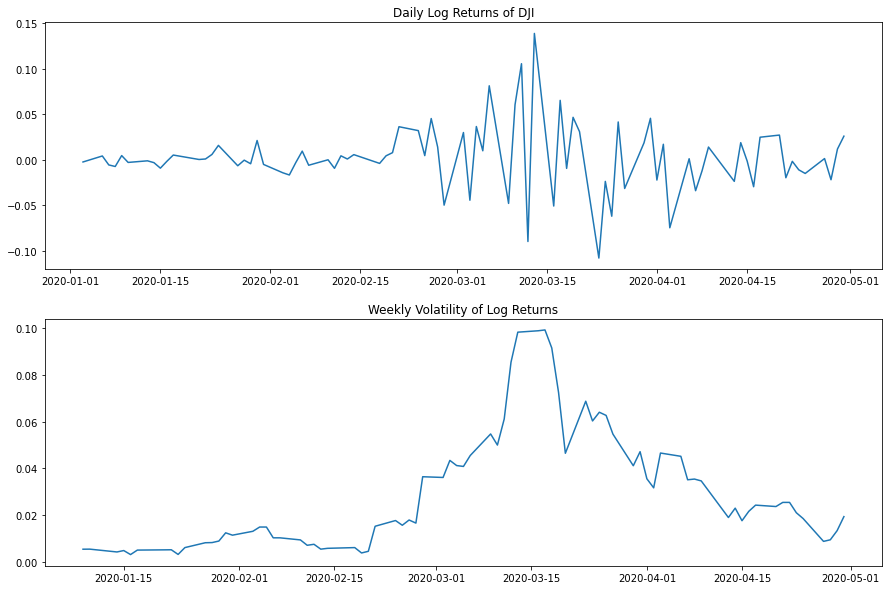

In [6]:
# The ticker we analyze for all the following parts => we chose an index (Dow Jones Industrial Average)
ticker = 'DJI'

fig, ax = plt.subplots(2,1, figsize=(15,10))

ax[0].set_title('Daily Log Returns of ' + ticker)
ax[0].plot(daily_returns['Date'], daily_returns[ticker])

ax[1].set_title('Weekly Volatility of Log Returns')
ax[1].plot(daily_returns['Date'], weekly_volatility[ticker])

plt.show()

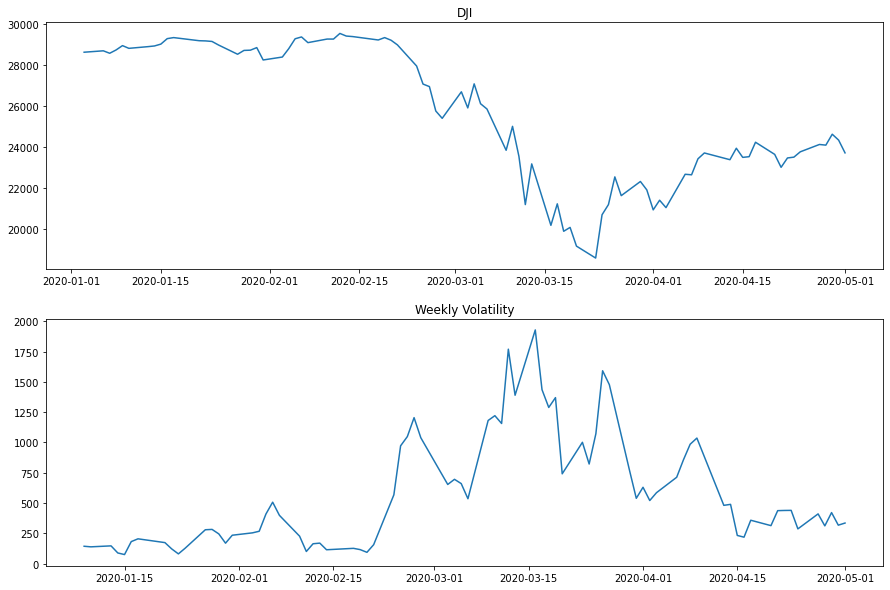

In [7]:
# Computing weekly volatility for the stocks
stocks_weekly_volatility = stocks.rolling(5).std()

fig, ax = plt.subplots(2,1, figsize=(15,10))

ax[0].set_title(ticker)
ax[0].plot(stocks['Date'], stocks[ticker])

ax[1].set_title('Weekly Volatility')
ax[1].plot(stocks['Date'], stocks_weekly_volatility[ticker])

plt.show()

## Base Model Selection

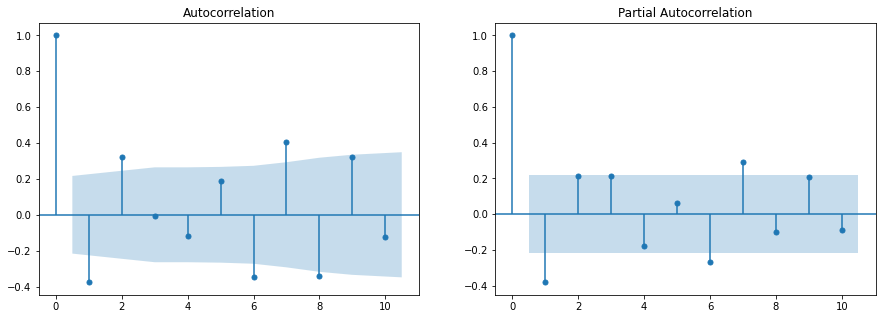

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

returns = daily_returns[['Date',ticker]].dropna()

# Some analysis for model selection (which lags seem important) => only lag 1,2 at most
fig, ax = plt.subplots(1,2, figsize=(15,5))
plot_acf(returns[ticker], lags=10, ax=ax[0])
plot_pacf(returns[ticker], lags=10, ax=ax[1])
plt.show()

In [9]:
# This is an important package we use in all the following parts to model the data. 
# It contains useful models and forecasts for financial time series.

"""
What arch does and how we can use it for this project :

mean  = give a mean model - ARX is AR with exogenous (which is google trends for the next part)
vol   = give a volatility model
x     = exogenous predictors
lags  = for mean ARX
p,o,q = GARCH parameters
dist  = distribution of residuals

"""

from arch import arch_model

In [10]:
# First model : GARCH on log daily returns (multiplied by 10 for scaling requirements by the arch package)
arch_res = arch_model(10*returns[ticker], mean='Zero', vol='GARCH', p=1, o=0, q=1, dist='StudentsT').fit(disp='off')
print(arch_res.summary())

                          Zero Mean - GARCH Model Results                           
Dep. Variable:                          DJI   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.012
Vol Model:                            GARCH   Log-Likelihood:                4.39503
Distribution:      Standardized Student's t   AIC:                         -0.790064
Method:                  Maximum Likelihood   BIC:                           8.83681
                                              No. Observations:                   82
Date:                      Sun, Dec 13 2020   Df Residuals:                       78
Time:                              19:13:33   Df Model:                            4
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
o

<AxesSubplot:>

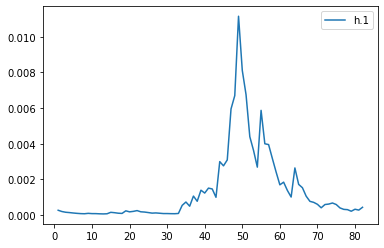

In [11]:
# Predicting variance (we need to rescale divide by scale^2 = 100)
variance_forecasts = arch_res.forecast(horizon=1, start=0).variance/100
variance_forecasts.plot()

<AxesSubplot:>

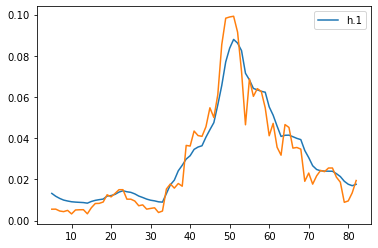

In [12]:
# Predicted volatility
weekly_std_forecast = np.sqrt(variance_forecasts.rolling(5).mean())
weekly_std_forecast.plot()
weekly_volatility[ticker].plot()

---

## Google Trends data using Pytrends:

In [13]:
from pytrends.request import TrendReq
from pytrends import dailydata

import time

def GetTrends(keywords, start_date, end_date):
    """
    returns the Google trends data (weekly and daily)
    
    :param keywords: the list of the keywords to search data for
    :param start_date: string of start_date. (Y-M-D format)
    :param end_date: string of end_date. (Y-M-D format)
    """
    
    startTime = time.time()
    
    timeframe = start_date +' '+ end_date
    
    start_date = datetime.date(datetime.strptime(start_date,"%Y-%m-%d"))
    end_date = datetime.date(datetime.strptime(end_date,"%Y-%m-%d"))

    start_year, start_month = start_date.year, start_date.month
    stop_year, stop_month = end_date.year, end_date.month
    
    # Connect to google trends
    # hl: host language (English)
    # timezone offset=360 (US CST)
    pytrends = TrendReq(hl='en-US', tz=360)

    # keywords list kw_list

    weekly_dataset = []
    
    daily_data = pd.DataFrame(columns=keywords)
    weekly_data = pd.DataFrame(columns=keywords)

    for keyword in keywords:
        
        # build payload for pytrends
        pytrends.build_payload(
        kw_list=[keyword],
        timeframe = timeframe)
        
        # get weekly data
        tmp_data = pytrends.interest_over_time()
        
        if not tmp_data.empty:
            weekly_data[keyword] = tmp_data[keyword]
            
        # get daily data
        col_name = keyword+"_unscaled"
        tmp_data = dailydata.get_daily_data(keyword,
                                              start_year,
                                              start_month,
                                              stop_year,
                                              stop_month,
                                              geo='US',
                                              verbose=False)[col_name]
        
        if not tmp_data.empty:
            daily_data[keyword] = tmp_data

    executionTime = (time.time() - startTime)
    print('Execution time in sec.: ' + str(executionTime))

        
    print("Google Trends data download success.")
    
    return weekly_data, daily_data

In [14]:
# List of possible keywords
keywords = ['debt','loan','job','unemployment','economics','inflation','sell','bonds','gold','stocks','dow jones', \
            'crisis','finance','risk','leverage']

keywords = ['unemployment','stocks','crisis','dow jones']

# Data already saved but here is how we got it
if(False):
    g_trends_weekly, g_trends_daily = GetTrends(keywords, start_date, end_date)
    SaveData(g_trends_weekly, 'weekly_google_trends')
    SaveData(g_trends_daily, 'daily_google_trends')
else:
    g_trends_daily = pd.read_csv('data/daily_google_trends.csv')
    g_trends_daily.set_index(g_trends_daily.date.astype('datetime64[ns]'), inplace=True)
    g_trends_daily.drop('date', axis=1, inplace=True)

In [15]:
g_trends_daily

,unemployment,stocks,crisis,dow jones
date,,,,
2020-01-01,38,51,21,20
2020-01-02,70,85,30,74
2020-01-03,66,100,34,92
2020-01-04,38,69,32,17
2020-01-05,74,56,29,6
...,...,...,...,...
2020-05-27,80,88,100,98
2020-05-28,66,92,92,97
2020-05-29,57,74,80,88


In [16]:
from statsmodels.tsa.seasonal import STL

# Creating non-seasonal time series for the Google queries (it actually improves the convergence of optimizer when fitting the model)
for keyword in keywords:
    g_trends_daily[keyword+'.nsa'] = g_trends_daily[keyword] - STL(g_trends_daily[keyword]).fit().seasonal
    
g_trends_daily

,unemployment,stocks,crisis,dow jones,unemployment.nsa,stocks.nsa,crisis.nsa,dow jones.nsa
date,,,,,,,,
2020-01-01,38,51,21,20,56.609303,61.085039,13.503984,22.151593
2020-01-02,70,85,30,74,69.564646,75.938709,27.519270,48.544424
2020-01-03,66,100,34,92,67.591305,83.159644,32.285541,56.735440
2020-01-04,38,69,32,17,68.699494,78.764815,37.609384,56.165219
2020-01-05,74,56,29,6,70.281637,77.030506,39.211897,58.770519
...,...,...,...,...,...,...,...,...
2020-05-27,80,88,100,98,71.142435,71.382745,90.803262,63.113949
2020-05-28,66,92,92,97,67.001982,73.114032,85.574513,61.466983
2020-05-29,57,74,80,88,69.049321,71.226393,82.558901,65.866208


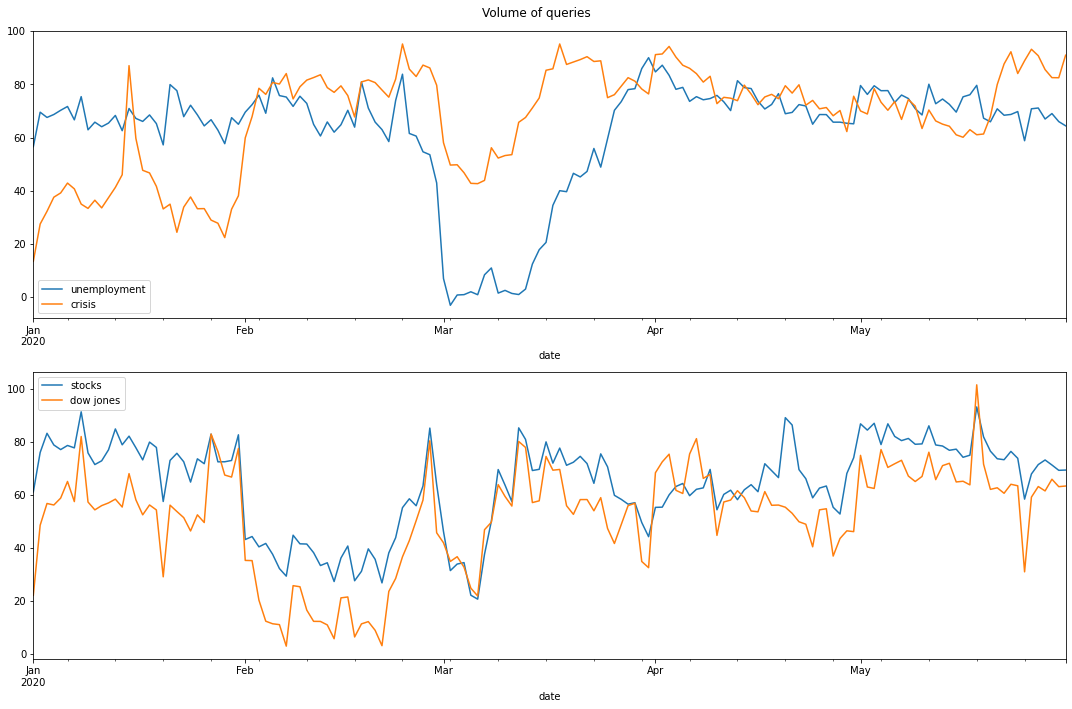

In [17]:
# Visualizing the non seasonal Google queries 
fig, axs = plt.subplots(2,figsize=(15,10))

for ind, keyword in enumerate(keywords):
    if ind % 2 == 0:
        g_trends_daily[keyword+'.nsa'].plot(ax=axs[0], label=keyword)
        axs[0].legend(loc='best')
    else:
        g_trends_daily[keyword+'.nsa'].plot(ax=axs[1], label=keyword)
        axs[1].legend(loc='best')
        
fig.suptitle("Volume of queries")
fig.tight_layout()
plt.show()

Let's try and plot some data with the google trends data:

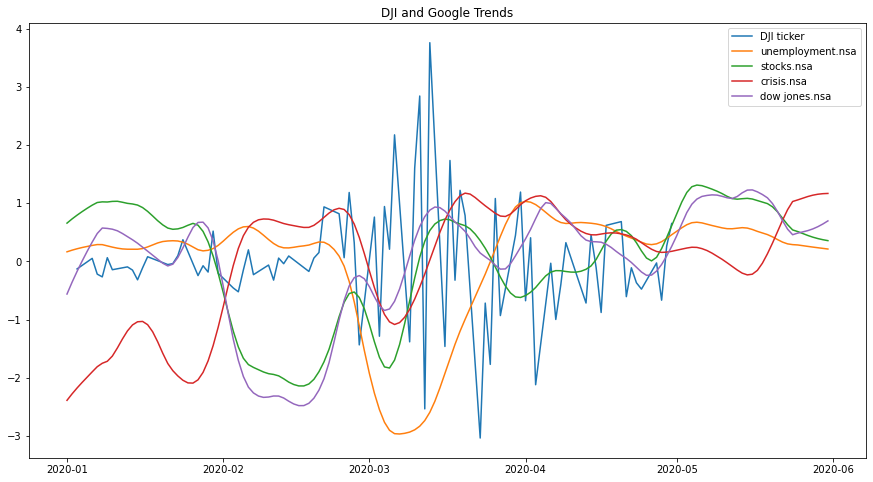

In [18]:
from sklearn.preprocessing import scale

# Visualizing queries trend and ticker log returns at the same scale
fig, ax = plt.subplots(figsize=(15,8))

ax.set_title(ticker + ' and Google Trends')
ax.plot(returns['Date'], scale(returns[ticker]), label=ticker+' ticker')
for keyword in keywords:
    trend = STL(g_trends_daily[keyword]).fit().trend
    ax.plot(g_trends_daily.index, scale(trend), label=keyword+'.nsa')
ax.legend(loc='best')

plt.show()

## Trends Model Selection

In [19]:
# After some testing the most significant are crisis and dow jones queries
arch_trends_res = arch_model(10*returns[ticker], 
                             mean='ARX', x=g_trends_daily[['dow jones.nsa','crisis.nsa']].loc[returns['Date']], 
                             vol='GARCH', p=1, o=0, q=1, dist='StudentsT').fit(disp='off')
print(arch_trends_res.summary())

                             AR-X - GARCH Model Results                             
Dep. Variable:                          DJI   R-squared:                       0.012
Mean Model:                            AR-X   Adj. R-squared:                 -0.013
Vol Model:                            GARCH   Log-Likelihood:                7.83264
Distribution:      Standardized Student's t   AIC:                          -1.66528
Method:                  Maximum Likelihood   BIC:                           15.1818
                                              No. Observations:                   82
Date:                      Sun, Dec 13 2020   Df Residuals:                       75
Time:                              19:13:34   Df Model:                            7
                                    Mean Model                                    
                     coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------------------

<AxesSubplot:>

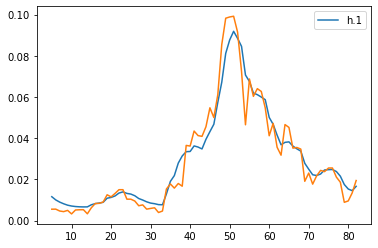

In [20]:
# Predicted volatility
variance_forecasts_trends = arch_trends_res.forecast(horizon=1, start=0).variance/100
weekly_std_trends_forecast = np.sqrt(variance_forecasts_trends.rolling(5).mean())
weekly_std_trends_forecast.plot()
weekly_volatility[ticker].plot()

## Comparing Models

In [21]:
from sklearn.metrics import mean_absolute_error

mae_base   = mean_absolute_error(weekly_volatility[ticker].dropna(), weekly_std_forecast.dropna());
mae_trends = mean_absolute_error(weekly_volatility[ticker].dropna(), weekly_std_trends_forecast.dropna());

print('MAE base = %.4f - MAE trends = %.4f' % (mae_base,mae_trends))

MAE base = 0.0055 - MAE trends = 0.0044


## Conclusion

# -_________-

### WHAT NEEDS TO BE DONE :
### Do the same thing I did for base and trends model but using rolling window with one step ahead prediction and then compute the MAEs
### OR
### training set before drop and the rest for testing and see how it performs during the drop